## Import packages

In [1]:
import sys
print(sys.version)

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.transforms import v2

import os
import pandas as pd

from PIL import Image
import rasterio

3.11.8 | packaged by conda-forge | (main, Feb 16 2024, 20:40:50) [MSC v.1937 64 bit (AMD64)]


## Import the tabular data

In [2]:
# list the .csv files in the folder
# for root, dirs, files in os.walk('../'):
#     for file in files:
#         if file.endswith('.csv'):
#             print(file)

In [3]:
# Specify the path to your CSV file
csv_file_path = '../buffalo_data_df_lag_1hr_n10000.csv'

# Read the CSV file into a DataFrame
buffalo_df = pd.read_csv(csv_file_path)

# Display the first few rows of the DataFrame
print(buffalo_df.head())

             x_            y_                    t_    id           x1_  \
0  41968.357479 -1.435673e+06  2018-07-25T01:04:23Z  2005  41968.357479   
1  41920.568545 -1.435656e+06  2018-07-25T02:04:39Z  2005  41920.568545   
2  41778.486205 -1.435602e+06  2018-07-25T03:04:17Z  2005  41778.486205   
3  41840.249881 -1.435637e+06  2018-07-25T04:04:39Z  2005  41840.249881   
4  41654.509951 -1.435606e+06  2018-07-25T05:04:27Z  2005  41654.509951   

            y1_           x2_           y2_     x2_cent    y2_cent  ...  \
0 -1.435673e+06  41920.568545 -1.435656e+06  -47.788934  16.857104  ...   
1 -1.435656e+06  41778.486205 -1.435602e+06 -142.082340  53.568411  ...   
2 -1.435602e+06  41840.249881 -1.435637e+06   61.763676 -34.322931  ...   
3 -1.435637e+06  41654.509951 -1.435606e+06 -185.739930  31.003515  ...   
4 -1.435606e+06  41617.698545 -1.435610e+06  -36.811406  -4.438040  ...   

           sl    log_sl   bearing        ta    cos_ta         x_min  \
0   50.674887  3.925430  2.

## Importing spatial data

In [4]:
# list the .tif files in the folder
# for root, dirs, files in os.walk('../'):
#     for file in files:
#         if file.endswith('.tif'):
#             print(file)

buffalo_canopy_cent100x100_lag_1hr_n1000.tif
buffalo_canopy_cent100x100_lag_1hr_n10000.tif
buffalo_canopy_cent100x100_lag_6hr_n10000.tif
buffalo_canopy_cent101x101_lag_1hr_n100.tif
buffalo_canopy_cent101x101_lag_1hr_n1000.tif
buffalo_canopy_cent101x101_lag_1hr_n10000.tif
buffalo_canopy_cent50x50_n10000.tif
buffalo_canopy_cent_n10000.tif
buffalo_herby_cent100x100_lag_1hr_n1000.tif
buffalo_herby_cent100x100_lag_1hr_n10000.tif
buffalo_herby_cent100x100_lag_6hr_n10000.tif
buffalo_herby_cent100x100_n10000.tif
buffalo_herby_cent101x101_lag_1hr_n100.tif
buffalo_herby_cent101x101_lag_1hr_n1000.tif
buffalo_herby_cent101x101_lag_1hr_n10000.tif
buffalo_herby_cent50x50_n10000.tif
buffalo_herby_cent_n10000.tif
buffalo_ndvi_cent100x100_lag_1hr_n1000.tif
buffalo_ndvi_cent100x100_lag_1hr_n10000.tif
buffalo_ndvi_cent100x100_lag_6hr_n10000.tif
buffalo_ndvi_cent101x101_lag_1hr_n100.tif
buffalo_ndvi_cent101x101_lag_1hr_n1000.tif
buffalo_ndvi_cent101x101_lag_1hr_n10000.tif
buffalo_ndvi_cent50x50_n10000.tif

## NDVI

In [5]:
file_path = '../buffalo_ndvi_cent101x101_lag_1hr_n10000.tif'
# with lag
# file_path = '../buffalo_ndvi_cent100x100_lag_6hr_n10000.tif'

# Using rasterio 
with rasterio.open(file_path) as ndvi:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    ndvi_stack = ndvi.read([i for i in range(1, ndvi.count + 1)])


In [6]:
print(ndvi_stack.shape)
# print(ndvi_stack.size)

ndvi_tens = torch.from_numpy(ndvi_stack)
print(ndvi_tens.shape)
print("Mean = ", torch.mean(ndvi_tens))

ndvi_max = torch.max(ndvi_tens)
ndvi_min = torch.min(ndvi_tens)

print("Max = ", ndvi_max)
print("Min = ", ndvi_min)

# Normalizing the data
ndvi_tens_norm = (ndvi_tens - ndvi_min) / (ndvi_max - ndvi_min)
print("Mean = ", torch.mean(ndvi_tens_norm))
print("Max = ", torch.max(ndvi_tens_norm))
print("Min = ", torch.min(ndvi_tens_norm))

# print(ndvi_tens_norm.dtype)


(9818, 101, 101)
torch.Size([9818, 101, 101])
Mean =  tensor(0.3056)
Max =  tensor(0.8220)
Min =  tensor(-0.2772)
Mean =  tensor(0.5302)
Max =  tensor(1.)
Min =  tensor(0.)


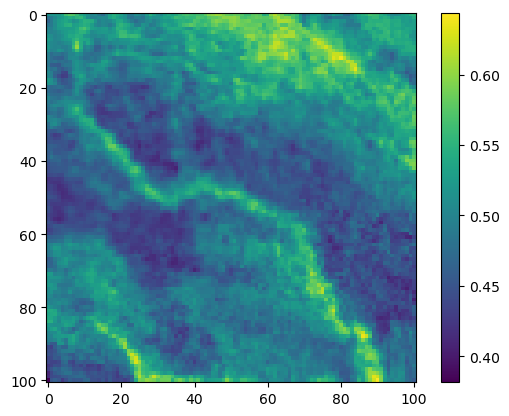

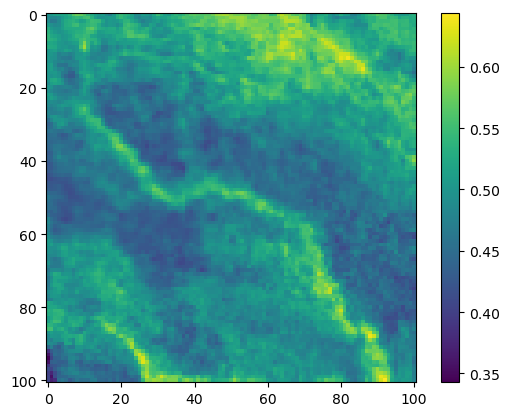

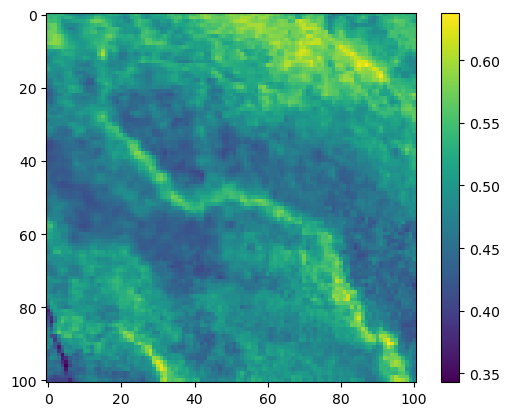

In [7]:
for i in range(0, 3):
    plt.imshow(ndvi_tens_norm[i].numpy())
    plt.colorbar()  
    plt.show()

## Canopy cover

In [8]:
# Path to your TIF file
file_path = '../buffalo_canopy_cent101x101_lag_1hr_n10000.tif'
# with lag
# file_path = '../buffalo_canopy_cent100x100_lag_6hr_n10000.tif'

# Using rasterio 
with rasterio.open(file_path) as canopy:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    canopy_stack = canopy.read([i for i in range(1, canopy.count + 1)])

print(canopy_stack.shape)

(9818, 101, 101)


In [9]:
print(canopy_stack.shape)
# print(canopy_stack.size)

canopy_tens = torch.from_numpy(canopy_stack)
print(canopy_tens.shape)
print("Mean = ", torch.mean(canopy_tens))

canopy_max = torch.max(canopy_tens)
canopy_min = torch.min(canopy_tens)

print("Max = ", canopy_max)
print("Min = ", canopy_min)

# Normalizing the data
canopy_tens_norm = (canopy_tens - canopy_min) / (canopy_max - canopy_min)
print("Mean = ", torch.mean(canopy_tens_norm))
print("Max = ", torch.max(canopy_tens_norm))
print("Min = ", torch.min(canopy_tens_norm))

# print(canopy_tens_norm.dtype)

(9818, 101, 101)
torch.Size([9818, 101, 101])
Mean =  tensor(44.1707)
Max =  tensor(82.5000)
Min =  tensor(0.)
Mean =  tensor(0.5354)
Max =  tensor(1.)
Min =  tensor(0.)


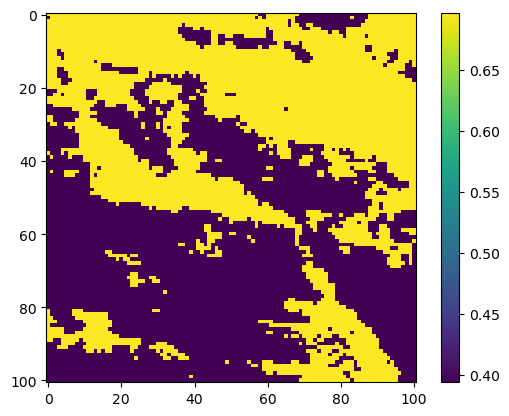

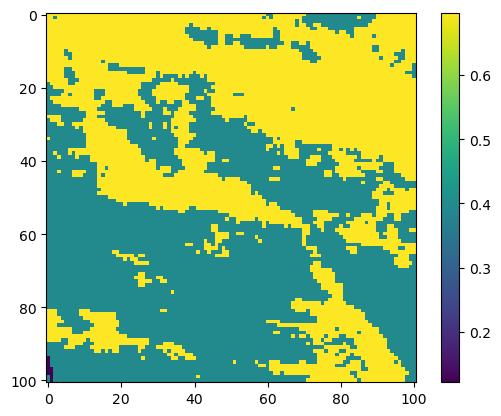

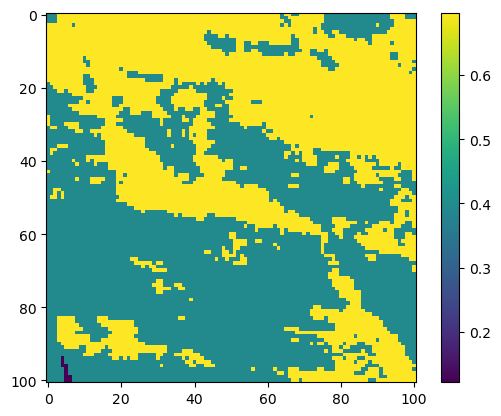

In [10]:
for i in range(0, 3):
    plt.imshow(canopy_tens_norm[i].numpy())
    plt.colorbar()  
    plt.show()

## Herbaceous vegetation

In [11]:
# Path to your TIF file
file_path = '../buffalo_herby_cent101x101_lag_1hr_n10000.tif'
# with lag
# file_path = '../buffalo_herby_cent100x100_lag_6hr_n10000.tif'

# Using rasterio 
with rasterio.open(file_path) as herby:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    herby_stack = herby.read([i for i in range(1, herby.count + 1)])

print(herby_stack.shape)      

(9818, 101, 101)


In [12]:
print(herby_stack.shape)
# print(canopy_stack.size)

herby_tens = torch.from_numpy(herby_stack)
print(herby_tens.shape)
print("Mean = ", torch.mean(herby_tens))

herby_max = torch.max(herby_tens)
herby_min = torch.min(herby_tens)

print("Max = ", herby_max)
print("Min = ", herby_min)

# Normalizing the data
herby_tens_norm = (herby_tens - herby_min) / (herby_max - herby_min)
print("Mean = ", torch.mean(herby_tens_norm))
print("Max = ", torch.max(herby_tens_norm))
print("Min = ", torch.min(herby_tens_norm))

# print(herby_tens_norm.dtype)

(9818, 101, 101)
torch.Size([9818, 101, 101])
Mean =  tensor(0.8094)
Max =  tensor(1.)
Min =  tensor(0.)
Mean =  tensor(0.8094)
Max =  tensor(1.)
Min =  tensor(0.)


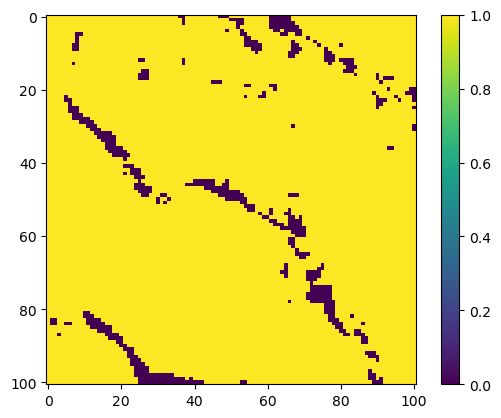

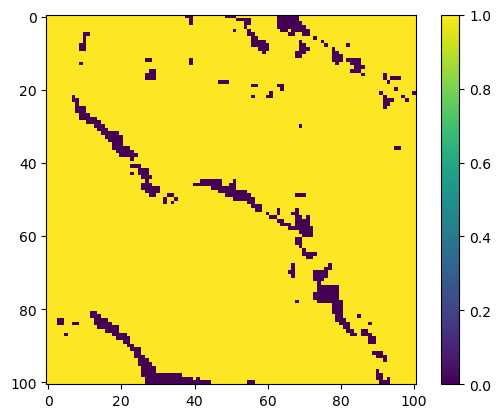

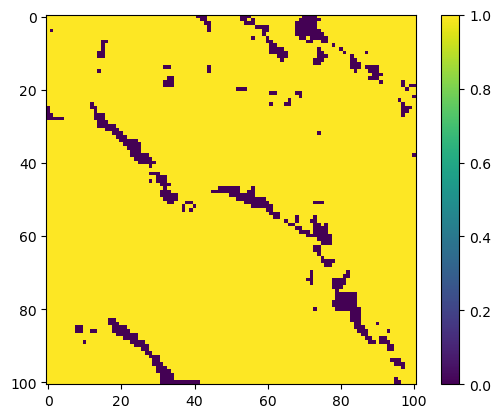

In [13]:
for i in range(0, 3):
    plt.imshow(herby_tens_norm[i])
    plt.colorbar()  
    plt.show()

## Slope

In [14]:
# Path to your TIF file
file_path = '../buffalo_slope_cent101x101_lag_1hr_n10000.tif'
# with lag
# file_path = '../buffalo_slope_cent100x100_lag_6hr_n10000.tif'

# Using rasterio 
with rasterio.open(file_path) as slope:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    slope_stack = slope.read([i for i in range(1, slope.count + 1)])

print(slope_stack.shape)

(9818, 101, 101)


In [15]:
print(slope_stack.shape)
# print(canopy_stack.size)

slope_tens = torch.from_numpy(slope_stack)
print(slope_tens.shape)
print("Mean = ", torch.mean(slope_tens))

slope_max = torch.max(slope_tens)
slope_min = torch.min(slope_tens)

print("Max = ", slope_max)
print("Min = ", slope_min)

# Normalizing the data
slope_tens_norm = (slope_tens - slope_min) / (slope_max - slope_min)
print("Mean = ", torch.mean(slope_tens_norm))
print("Max = ", torch.max(slope_tens_norm))
print("Min = ", torch.min(slope_tens_norm))

# print(slope_tens_norm.dtype)

(9818, 101, 101)
torch.Size([9818, 101, 101])
Mean =  tensor(0.7727)
Max =  tensor(12.2981)
Min =  tensor(0.0006)
Mean =  tensor(0.0628)
Max =  tensor(1.)
Min =  tensor(0.)


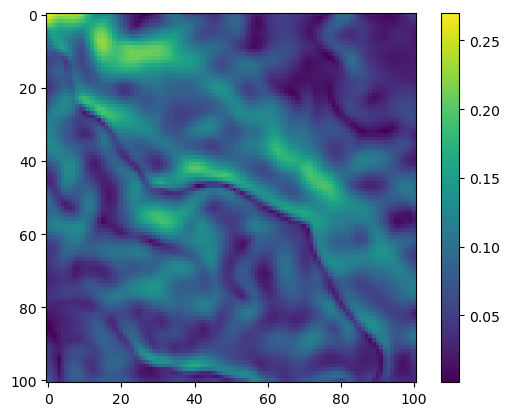

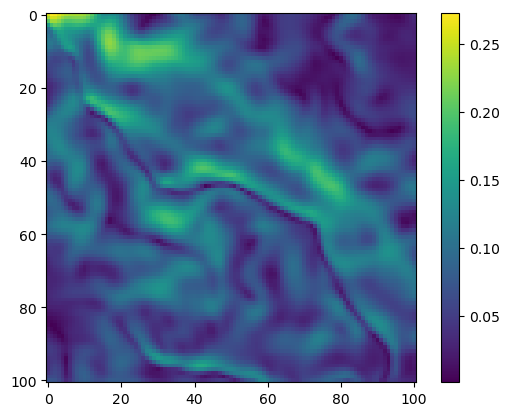

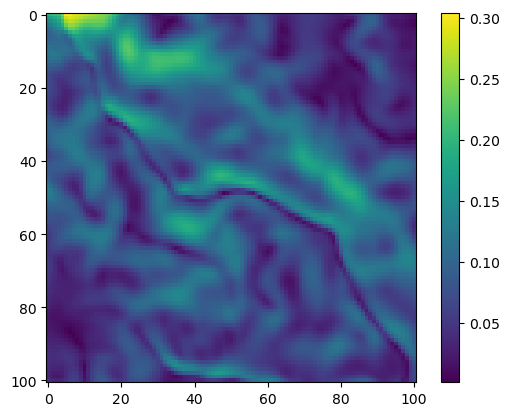

In [16]:
for i in range(0, 3):
    plt.imshow(slope_tens_norm[i])
    plt.colorbar()  
    plt.show()

## Presence records - target of model

In [17]:
# Path to your TIF file
file_path = '../buffalo_pres_cent101x101_lag_1hr_n10000.tif'
# with lag
# file_path = '../buffalo_pres_cent100x100_lag_6hr_n10000.tif'

# Using rasterio 
with rasterio.open(file_path) as pres:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    pres_stack = pres.read([i for i in range(1, pres.count + 1)])

print(pres_stack.shape)
print(type(pres_stack))

(9818, 101, 101)
<class 'numpy.ndarray'>


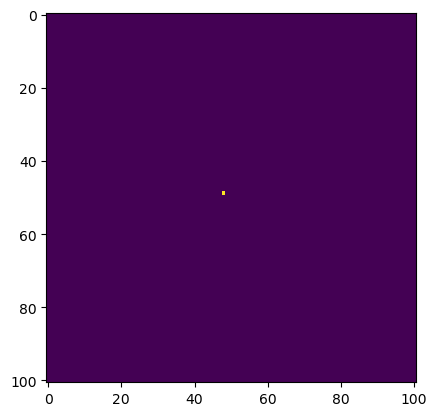

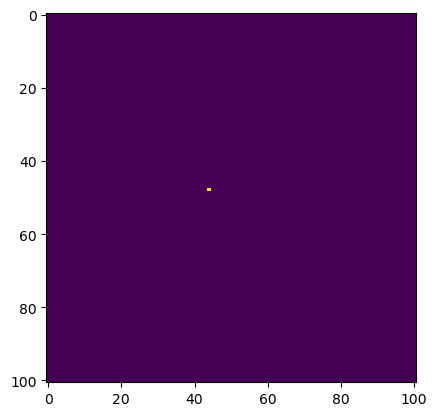

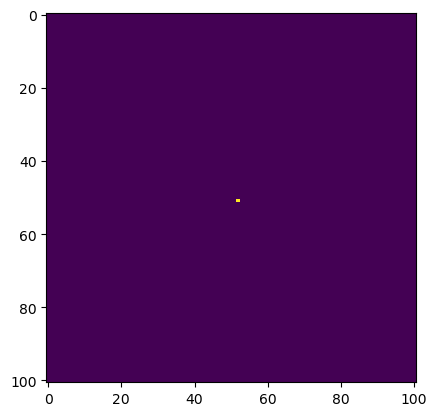

In [18]:
for i in range(0, 3):
    plt.imshow(pres_stack[i])
    plt.show()

Find the index of the occupied cell

In [19]:
# pres_stack
# Find the coordinates of the 1
coordinates = np.where(pres_stack[0] == 1)
print(coordinates)
x, y = coordinates[0][0], coordinates[1][0]
print(x, y)

(array([49], dtype=int64), array([48], dtype=int64))
49 48


In [20]:
# Convert coordinates to single index for CrossEntropyLoss
index = x * 101 + y
print(index)

4997


Now do for all locations

In [21]:
# Iterate over all the layers in the stack and store the coordinates of the 1
indices = []
for i in range(0, pres.count-1):
    # print(i)
    coordinates = np.where(pres_stack[i] == 1)
    x, y = coordinates[0][0], coordinates[1][0]
    index = x * 101 + y
    indices.append(index)


In [22]:
print(indices)
# how many entries in indices
print(len(indices))

[4997, 4892, 5203, 4992, 5099, 7224, 5100, 5100, 4383, 4662, 4795, 4593, 5100, 5100, 5100, 5499, 6622, 5218, 5100, 5100, 5100, 5522, 6833, 2910, 4084, 4375, 4689, 5194, 6420, 5100, 5100, 5100, 5100, 4487, 3467, 5698, 4494, 5196, 5100, 5100, 4705, 5306, 6124, 4904, 5204, 5295, 5100, 4998, 6321, 5099, 5100, 5199, 6594, 5100, 5100, 5186, 4495, 5514, 5205, 5100, 5100, 5100, 5100, 5100, 5100, 6633, 6022, 2706, 5097, 2136, 6312, 5100, 5100, 5502, 6197, 6424, 5109, 4801, 5100, 5100, 5100, 5193, 4900, 5100, 5100, 6512, 5306, 5406, 4895, 4909, 5099, 6412, 5100, 5100, 5100, 5100, 3893, 6209, 5098, 5100, 5100, 5100, 5100, 5100, 5100, 5903, 8231, 5106, 5204, 5203, 3108, 3377, 7308, 5100, 5100, 5100, 5788, 5488, 5602, 5503, 4899, 5512, 4192, 2769, 4999, 5100, 5100, 5100, 5100, 4199, 3997, 4508, 5205, 5715, 5403, 4390, 5300, 5491, 5098, 5100, 5100, 4268, 5680, 5099, 5917, 5408, 5001, 5100, 5100, 4999, 5202, 5100, 5100, 6516, 6732, 5100, 5011, 780, 4897, 5099, 4792, 4890, 5301, 6004, 5100, 4784, 6908

In [23]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using {device} device")

Using cpu device


# Starting to build up a model

Combing the data into a TensorDataSet

In [24]:
# print(sl_ta[0:800])

Combine the spatial layers into channels

In [25]:
# Stack the channels along a new axis; here, 1 is commonly used for channel axis in PyTorch
# combined_stack = np.stack([ndvi_stack_norm, canopy_stack, herby_stack, slope_stack], axis=1)
combined_stack = torch.stack([ndvi_tens_norm, canopy_tens_norm, herby_tens_norm, slope_tens_norm], dim=1)
combined_stack
print(combined_stack.shape)

torch.Size([9818, 4, 101, 101])


Convert the target rasters into torch tensors

In [26]:
pres_tensor = torch.from_numpy(pres_stack)
type(pres_tensor)
len(pres_tensor)

9818

In [27]:
# Convert to a torch tensor (if using as a target for loss calculation)
# target = torch.tensor([indices], dtype=torch.long)

train_prop = 0.8

train_n = round(combined_stack.shape[0] * train_prop)
print(train_n)
# print(combined_stack.shape[0] * (1 - train_prop))

# length of training data (not used)
test_n = round(combined_stack.shape[0] * (1 - train_prop))
print(test_n)

# total length of the training data
total_n = len(pres_tensor)
print(total_n)


7854
1964
9818


## Defining data sets and data loaders

In [28]:
# set up some hyperparameters
bs = 32

# train_ds = TensorDataset(torch.from_numpy(combined_stack[0:train_n]), torch.tensor(indices[0:train_n], dtype=torch.long))
# print(train_ds)
# print(train_ds.tensors)
# train_dl = DataLoader(train_ds, batch_size=bs, shuffle = True)

# convert to a tensor
# sl_ta = torch.tensor(sl_ta[0:train_n], dtype=torch.float32)
# print(sl_ta)

train_ds = TensorDataset(combined_stack[1:train_n], torch.tensor(pres_stack[1:train_n]))
print(train_ds)
print(train_ds.tensors)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle = True)

test_ds = TensorDataset(combined_stack[train_n:total_n], torch.tensor(pres_stack[train_n:total_n]))
# print(train_ds)
# print(train_ds.tensors)
test_dl = DataLoader(test_ds, batch_size=bs, shuffle = True)


(tensor([[[[4.9656e-01, 5.0458e-01, 5.1537e-01,  ..., 5.1072e-01,
           5.2801e-01, 5.3339e-01],
          [4.8611e-01, 4.8244e-01, 4.8098e-01,  ..., 5.3293e-01,
           5.2536e-01, 5.2991e-01],
          [4.8828e-01, 4.6479e-01, 4.6754e-01,  ..., 5.4326e-01,
           5.2602e-01, 5.2828e-01],
          ...,
          [4.0090e-01, 3.7465e-01, 4.1066e-01,  ..., 5.1019e-01,
           5.1135e-01, 4.7096e-01],
          [4.0465e-01, 3.5697e-01, 4.1307e-01,  ..., 5.1176e-01,
           5.0510e-01, 4.7342e-01],
          [4.0522e-01, 3.6900e-01, 3.8134e-01,  ..., 5.0719e-01,
           5.0061e-01, 4.7598e-01]],

         [[6.9697e-01, 6.9697e-01, 6.9697e-01,  ..., 6.9697e-01,
           6.9697e-01, 6.9697e-01],
          [6.9697e-01, 6.9697e-01, 3.9394e-01,  ..., 6.9697e-01,
           6.9697e-01, 6.9697e-01],
          [6.9697e-01, 6.9697e-01, 6.9697e-01,  ..., 6.9697e-01,
           6.9697e-01, 6.9697e-01],
          ...,
          [1.2121e-01, 1.2121e-01, 3.9394e-01,  ..., 6.969

In [29]:
print(train_dl)
print(train_dl.dataset.tensors[0].shape)
print(test_dl.dataset.tensors[0].shape)

print(train_dl.dataset.tensors[1].shape)
print(test_dl.dataset.tensors[1].shape)

torch.Size([7853, 4, 101, 101])
torch.Size([1964, 4, 101, 101])
torch.Size([7853, 101, 101])
torch.Size([1964, 101, 101])


Creating a dataset class

In [30]:
torch.from_numpy(buffalo_df[['hour_t2', 'yday_t2']].values)

tensor([[ 12, 206],
        [ 13, 206],
        [ 14, 206],
        ...,
        [  1, 290],
        [  2, 290],
        [  3, 290]])

In [31]:
class buffalo_data(Dataset):

    def __init__(self):
        # data loading
        self.spatial_data_x = combined_stack
        # convert to tensor and change from int to float
        self.additional_data_x = torch.from_numpy(buffalo_df[['hour_t2', 'yday_t2']].values).float()
        self.target = torch.tensor(pres_stack)
        self.n_samples = self.spatial_data_x.shape[0]

    def __len__(self):
        # len(data)
        return self.n_samples

    def __getitem__(self, index):
        # allows for indexing of the dataset
        return self.spatial_data_x[index], self.additional_data_x[index], self.target[index]

In [32]:
dataset = buffalo_data()
first_data = dataset[:,0]
# print(first_data)
print(dataset.n_samples)

features1, features2, labels = first_data
print(features2.shape)

# dataset.shape
# print(dataset[0,:])

9818
torch.Size([9818])


Create dataloader

In [33]:
bs = 32 # batch size
dataloader = DataLoader(dataset=dataset, batch_size=bs, shuffle=True)

In [34]:
# Display image and label.
features1, features2, labels = next(iter(dataloader))
print(f"Feature batch shape: {features1.size()}")
print(f"Feature batch shape: {features2.size()}")
print(f"Labels batch shape: {labels.size()}")

Feature batch shape: torch.Size([32, 4, 101, 101])
Feature batch shape: torch.Size([32, 2])
Labels batch shape: torch.Size([32, 101, 101])


## Define the model

In [35]:
class Conv2d_block(nn.Module):
    def __init__(self, params):
        super(Conv2d_block, self).__init__()
        self.batch_size = params.batch_size
        self.input_channels = params.input_channels
        self.output_channels = params.output_channels
        self.kernel_size = params.kernel_size
        self.stride = params.stride
        self.kernel_size_mp = params.kernel_size_mp
        self.stride_mp = params.stride_mp
        self.padding = params.padding
        self.image_dim = params.image_dim
        self.device = params.device

        self.conv2d = nn.Sequential(
        nn.Conv2d(in_channels=self.input_channels, out_channels=self.output_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=self.kernel_size_mp, stride=self.stride_mp),
        nn.Conv2d(in_channels=self.output_channels, out_channels=self.output_channels, kernel_size=self.kernel_size, stride=self.kernel_size, padding=self.padding),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=self.kernel_size_mp, stride=self.stride_mp),
        nn.Flatten())

    def forward(self, x):
        return self.conv2d(x)

class FCN_block_all_habitat(nn.Module):
    def __init__(self, params):
        super(FCN_block_all_habitat, self).__init__()
        self.batch_size = params.batch_size
        self.dense_dim_in_all = params.dense_dim_in_all
        self.dense_dim_hidden = params.dense_dim_hidden
        self.dense_dim_out = params.dense_dim_out
        self.image_dim = params.image_dim
        self.device = params.device
        self.dropout = params.dropout

        self.ffn = nn.Sequential(nn.Linear(self.dense_dim_in_all, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.image_dim * self.image_dim)
        )
    
    def forward(self, x):
        return self.ffn(x)


class FCN_block_all_movement(nn.Module):
    def __init__(self, params):
        super(FCN_block_all_movement, self).__init__()
        self.batch_size = params.batch_size
        self.dense_dim_in_all = params.dense_dim_in_all
        self.dense_dim_hidden = params.dense_dim_hidden
        self.dense_dim_out = params.dense_dim_out
        self.image_dim = params.image_dim
        self.device = params.device
        self.num_movement_params = params.num_movement_params
        self.dropout = params.dropout

        self.ffn = nn.Sequential(nn.Linear(self.dense_dim_in_all, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.num_movement_params)
        )
    
    def forward(self, x):
        return self.ffn(x)
    
class FCN_block_nonspatial(nn.Module):
    def __init__(self, params):
        super(FCN_block_nonspatial, self).__init__()
        self.batch_size = params.batch_size
        self.dense_dim_in_nonspatial = params.dense_dim_in_nonspatial
        self.dense_dim_hidden = params.dense_dim_hidden
        self.dense_dim_out = params.dense_dim_out
        self.image_dim = params.image_dim
        self.device = params.device
        self.dropout = params.dropout

        self.ffn = nn.Sequential(nn.Linear(self.dense_dim_in_nonspatial, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.dense_dim_out)
        )
    
    def forward(self, x):
        return self.ffn(x)

class Params_to_Grid_Block(nn.Module):
    def __init__(self, params):
        super(Params_to_Grid_Block, self).__init__()
        self.batch_size = params.batch_size
        self.image_dim = params.image_dim
        self.pixel_size = params.pixel_size
        self.center = self.image_dim // 2
        y, x = np.indices((self.image_dim, self.image_dim))
        self.distance_layer = torch.from_numpy(1.0 + np.sqrt((self.pixel_size*(x - self.center))**2 + (self.pixel_size*(y - self.center))**2))
        self.bearing_layer = torch.from_numpy(np.arctan2(y - self.center, x - self.center))
        self.device = params.device

    def gamma_density(self, x, shape, scale):
        return -1*torch.lgamma(shape) -shape*torch.log(scale) + (shape - 1)*torch.log(x) - x/scale
        # return torch.exp(-1*torch.lgamma(shape) -shape*torch.log(scale) + (shape - 1)*torch.log(x) - x/scale)
    
    def vonmises_density(self, x, kappa, loc):
        return kappa*torch.cos(x - loc) - 1*(np.log(2*torch.pi) + torch.log(torch.special.i0(kappa)))
        # return torch.exp(kappa*torch.cos(x - loc) - 1*(np.log(2*torch.pi) + torch.log(torch.special.i0(kappa))))
    
    def forward(self, x):
        gamma_shape = 1.0 + torch.exp(x[:, 0]).unsqueeze(0).unsqueeze(0)
        gamma_shape = gamma_shape.repeat(self.image_dim, self.image_dim, 1)
        gamma_shape = gamma_shape.permute(2, 0, 1)

        gamma_scale = torch.exp(x[:, 1]).unsqueeze(0).unsqueeze(0)
        gamma_scale = gamma_scale.repeat(self.image_dim, self.image_dim, 1)
        gamma_scale = gamma_scale.permute(2, 0, 1)

        vonmises_kappa = torch.exp(x[:, 2]).unsqueeze(0).unsqueeze(0)
        vonmises_kappa = vonmises_kappa.repeat(self.image_dim, self.image_dim, 1)
        vonmises_kappa = vonmises_kappa.permute(2, 0, 1)

        vonmises_loc = x[:, 3].unsqueeze(0).unsqueeze(0)
        vonmises_loc = vonmises_loc.repeat(self.image_dim, self.image_dim, 1)
        vonmises_loc = vonmises_loc.permute(2, 0, 1)

        gamma_density_layer = self.gamma_density(self.distance_layer, gamma_shape, gamma_scale)
        vonmises_density_layer = self.vonmises_density(self.bearing_layer, vonmises_kappa, vonmises_loc)

        # movement_grid = gamma_density_layer*vonmises_density_layer
        # movement_grid = movement_grid/torch.sum(movement_grid)

        movement_grid = gamma_density_layer + vonmises_density_layer # when the Gamma and von Mises densities are on the log-scale
        movement_grid = movement_grid - torch.logsumexp(movement_grid, dim = (1, 2), keepdim = True)

        return movement_grid

class Vector_to_Grid_Block(nn.Module):
    def __init__(self, params):
        super(Vector_to_Grid_Block, self).__init__()
        self.batch_size = params.batch_size
        self.image_dim = params.image_dim
        self.device = params.device
    
    def forward(self, x):
        x_unnorm = x.reshape(x.shape[0], self.image_dim, self.image_dim)
        x_norm = x_unnorm - torch.logsumexp(x_unnorm, dim = (1, 2), keepdim = True)
        return x_norm
    
        # x_norm = x_unnorm/torch.sum(x_unnorm)
        # return x_norm


class ConvJointModel(nn.Module):
    def __init__(self, params):
        super(ConvJointModel, self).__init__()
        self.conv_habitat = Conv2d_block(params)
        self.fcn_habitat_all = FCN_block_all_habitat(params)
        self.fcn_habitat_nonspatial = FCN_block_nonspatial(params)
        self.habitat_grid_output = Vector_to_Grid_Block(params)

        self.conv_movement = Conv2d_block(params)
        self.fcn_movement_all = FCN_block_all_movement(params)
        self.fcn_movement_nonspatial = FCN_block_nonspatial(params)
        self.movement_grid_output = Params_to_Grid_Block(params)
        self.device = params.device



    def forward(self, x):
        spatial_data_x = x[0]
        additional_data_x = x[1]

        conv_habitat = self.conv_habitat(spatial_data_x)
        covariates_habitat = self.fcn_habitat_nonspatial(additional_data_x)
        all_predictors_habitat = torch.cat([conv_habitat, covariates_habitat], dim = 1)
        # print(f"Shape after concatenation: {all_predictors_habitat.shape}")  # Debugging print
        output_habitat = self.fcn_habitat_all(all_predictors_habitat)
        output_habitat = self.habitat_grid_output(output_habitat)

        conv_movement = self.conv_movement(spatial_data_x)
        covariates_movement = self.fcn_movement_nonspatial(additional_data_x)
        all_predictors_movement = torch.cat([conv_movement, covariates_movement], dim = 1)
        output_movement = self.fcn_movement_all(all_predictors_movement)
        output_movement = self.movement_grid_output(output_movement)

        output = torch.stack((output_habitat, output_movement), dim = -1)
        return output
    
class ModelParams():
    def __init__(self, dict_params):
        self.batch_size = dict_params["batch_size"]
        self.image_dim = dict_params["image_dim"]
        self.pixel_size = dict_params["pixel_size"]
        self.batch_size = dict_params["batch_size"]
        self.dense_dim_in_nonspatial = dict_params["dense_dim_in_nonspatial"]
        self.dense_dim_hidden = dict_params["dense_dim_hidden"]
        self.dense_dim_out = dict_params["dense_dim_out"]
        self.batch_size = dict_params["batch_size"]
        self.dense_dim_in_all = dict_params["dense_dim_in_all"]
        self.dense_dim_hidden = dict_params["dense_dim_hidden"]
        self.dense_dim_out = dict_params["dense_dim_out"]
        self.batch_size = dict_params["batch_size"]
        self.input_channels = dict_params["input_channels"]
        self.output_channels = dict_params["output_channels"]
        self.kernel_size = dict_params["kernel_size"]
        self.stride = dict_params["stride"]
        self.kernel_size_mp = dict_params["kernel_size_mp"]
        self.stride_mp = dict_params["stride_mp"]
        self.padding = dict_params["padding"]
        self.image_dim = dict_params["image_dim"]
        self.num_movement_params = dict_params["num_movement_params"]
        self.dropout = dict_params["dropout"]
        self.device = dict_params["device"]


Take a look at the model's structure

In [36]:
params_dict = {"batch_size": 32,
               "image_dim": 101, #number of pixels along the edge of each local patch/image
               "pixel_size": 25, #number of metres along the edge of a pixel
               "dense_dim_in_nonspatial": 2, #change this to however many other scalar predictors you have (bearing, velocity etc)
               "dense_dim_hidden": 128, #number of nodes in the hidden layers
               "dense_dim_out": 128, #number of nodes in the output of the fully connected block (FCN)
               "dense_dim_in_all": 256 + 128, #number of inputs entering the fully connected block once the nonspatial features have been concatenated to the spatial features
               "input_channels": 4, #number of spatial layers in each image
               "output_channels": 16, #number of filters to learn
               "kernel_size": 3, #the size of the 2D moving windows / kernels that are being learned
               "stride": 2, #the stride used when applying the kernel.  This reduces the dimension of the output
               "kernel_size_mp": 2, #the size of the kernel that is used in max pooling operations
               "stride_mp": 2, #the stride that is used in max pooling operations
               "padding": 1, #the amount of padding to apply to images prior to applying the 2D convolution
               "num_movement_params": 4, #number of parameters used to parameterise the movement kernel
               "dropout": 0.1,
               "device": device
               }

params = ModelParams(params_dict)
model = ConvJointModel(params).to(device)
# print(model)

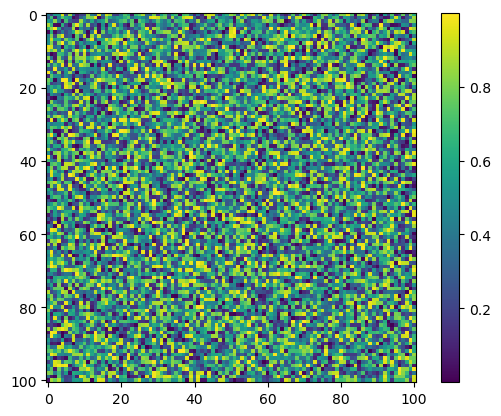

In [37]:
X = []
X.append(torch.rand(1, 4, 101, 101, device=device)) #spatial data
X.append(torch.rand(1, 5, device=device)) #other scalar covariates
# print(type(X))
# print(X[0].detach().cpu().numpy())

# plot the results of the movement density as an image
plt.imshow(X[0].detach().cpu().numpy()[0, 0, :,:])
plt.colorbar()
plt.show()

# # plot the results of the movement density as an image
# plt.imshow(X.detach().numpy()[0,:,:,1])
# plt.colorbar()
# plt.show()

In [38]:
test_batch = 2
x1 = (torch.rand(test_batch, 4, 101, 101, device=device)) #spatial data
x2 = (torch.rand(test_batch, 2, device=device)) #other scalar covariates
# y = (torch.rand(1, 1, 101, 101, device=device)) #spatial data

# synth_ds = TensorDataset(x1, x2, y)
# synth_dl = DataLoader(synth_ds, batch_size=1, shuffle=True)

torch.Size([2, 101, 101, 2])


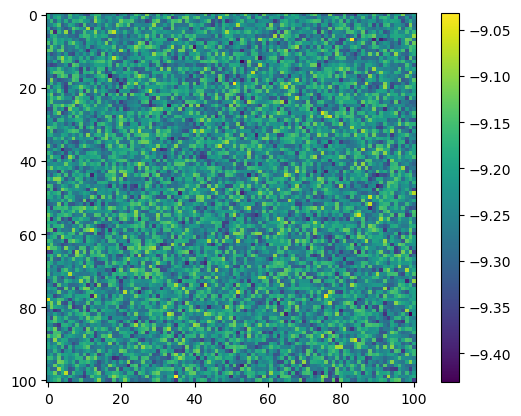

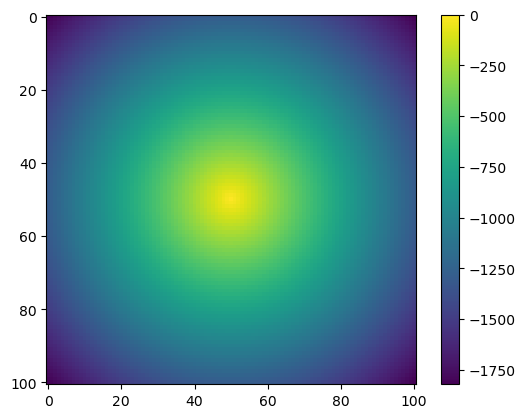

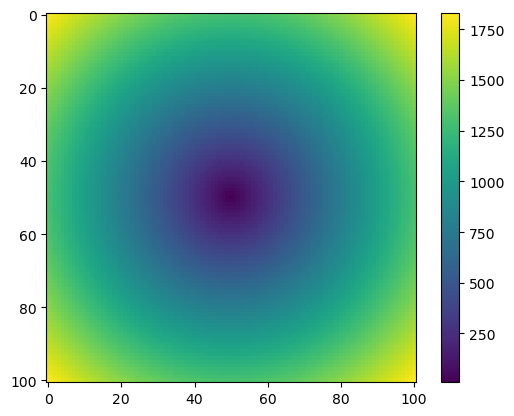

In [39]:
#Test that the model runs
# x1, x2 = synth_ds[0][0], synth_ds[0][1]
test = model((x1, x2))
print(test.shape)
# print(test)

# plot the results of the movement density as an image
plt.imshow(test.detach().numpy()[1,:,:,0])
plt.colorbar()
plt.show()

# plot the results of the movement density as an image
plt.imshow(test.detach().numpy()[0,:,:,1])
plt.colorbar()
plt.show()

test_cat = -1 * (test[:, :, :, 0] + test[:, :, :, 1])
# test_cat = torch.log(test[:, :, :, 0]*test[:, :, :, 1])

plt.imshow(test_cat.detach().numpy()[0,:,:])
plt.colorbar()
plt.show()

tensor([[[-11.0118, -10.9780, -10.9445,  ..., -10.2519, -10.2781, -10.3047],
         [-10.9851, -10.9511, -10.9174,  ..., -10.2176, -10.2440, -10.2709],
         [-10.9589, -10.9247, -10.8907,  ..., -10.1836, -10.2103, -10.2375],
         ...,
         [-10.9589, -10.9247, -10.8907,  ..., -10.1836, -10.2103, -10.2375],
         [-10.9851, -10.9511, -10.9174,  ..., -10.2176, -10.2440, -10.2709],
         [-11.0118, -10.9780, -10.9445,  ..., -10.2519, -10.2781, -10.3047]]],
       dtype=torch.float64)


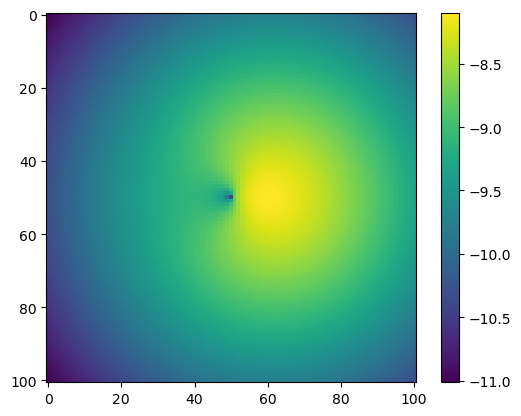

In [40]:
test_block = Params_to_Grid_Block(params)
# movement_density = test_block(torch.rand(1, 4, device=device))
# provide a tensor of shape (batch_size, 4) where the 4 columns are the parameters of the gamma and von mises distributions
# providing values in log space as the values are exponentiated in the forward pass
movement_density = test_block(torch.tensor([[np.log(0.5), np.log(500), np.log(0.5), 0]], device=device))
# providing values as the model sees them
# movement_density = test_block(torch.tensor([[-.5, -.5, -.5, -.5]], device=device))
print(movement_density)

# plot the results of the movement density as an image
plt.imshow(movement_density[0])
plt.colorbar()
plt.show()

## Loss function and optimizer

In [41]:
# Custom loss function to work with the two heatmaps that the model outputs

class negativeLogLikeLoss(nn.Module):
    def __init__(self, reduction='mean'):
        super(negativeLogLikeLoss, self).__init__()
        assert reduction in ['mean', 'sum', 'none'], "reduction should be 'mean', 'sum', or 'none'"
        self.reduction = reduction  # Assign reduction to self.reduction
    
    def forward(self, predict, target):
        predict_prod = predict[:, :, :, 0] + predict[:, :, :, 1]          # elementwise summation of the two heatmaps - for log-densities
        # predict_prod = predict[:, :, :, 0]*predict[:, :, :, 1]          # elementwise product of the two heatmaps
        # predict_prod = predict_prod/torch.sum(predict_prod)             # normalise the product of the two heatmaps
        # negLogLike = -1*(predict_prod * target)
        
        # Check for NaNs in the product
        if torch.isnan(predict_prod).any():
            print("NaNs detected in predict_prod")
            print("predict_prod:", predict_prod)
            raise ValueError("NaNs detected in predict_prod")
        
        # predict_prod = predict_prod / torch.sum(predict_prod)  # normalise the product of the two heatmaps
        
        # Check for NaNs after normalization
        # if torch.isnan(predict_prod).any():
        #     print("NaNs detected after normalization")
        #     print("predict_prod:", predict_prod)
        #     raise ValueError("NaNs detected after normalization")
        
        negLogLike = -1 * (predict_prod * target)
        # negLogLike = -1 * torch.log(predict_prod * target)
        
        # Check for NaNs in the negative log likelihood
        if torch.isnan(negLogLike).any():
            print("NaNs detected in negLogLike")
            print("negLogLike:", negLogLike)
            raise ValueError("NaNs detected in negLogLike")

        if self.reduction == 'mean':
            return torch.mean(negLogLike)
        elif self.reduction == 'sum':
            return torch.sum(negLogLike)
        elif self.reduction == 'none':
            return negLogLike
        return negLogLike

optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = negativeLogLikeLoss(reduction='mean')

### Instantiate the model

In [50]:
params = ModelParams(params_dict)
model = ConvJointModel(params).to(device)
# print(model)

torch.Size([2, 101, 101, 2])


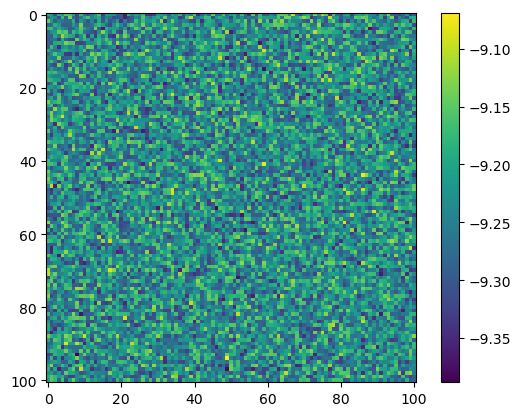

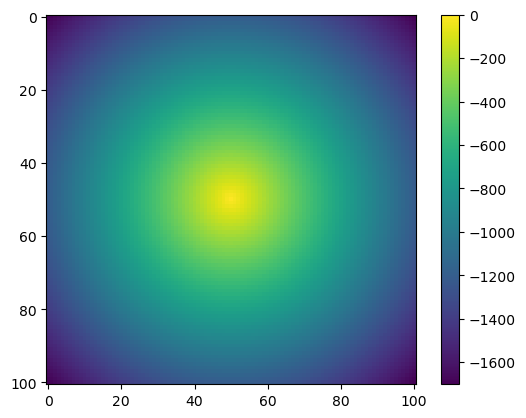

1.0000000000000002


In [47]:
# 1. Set the model in evaluation mode
model.eval()

#Test that the model runs
# x1, x2 = synth_ds[0][0], synth_ds[0][1]
test = model((x1, x2))
print(test.shape)
# print(test)

# # plot the results of the movement density as an image
plt.imshow(test.detach().numpy()[1,:,:,0])
plt.colorbar()
plt.show()

# # plot the results of the movement density as an image
plt.imshow(test.detach().numpy()[0,:,:,1])
plt.colorbar()
plt.show()

print(np.sum(np.exp(test.detach().numpy()[0,:,:,1])))

# test_cat = test[:, :, :, 0]*test[:, :, :, 1] 
# test_cat = test_cat/torch.sum(test_cat) 
# print(test_cat.shape)

# test_cat = -1 * torch.log(test[:, :, :, 0]*test[:, :, :, 1] )
# print(test_cat.shape)

# plt.imshow(test_cat.detach().numpy()[0,:,:])
# plt.colorbar()
# plt.show()

## Training loop

In [51]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (x1, x2, y) in enumerate(dataloader):
        
        # calculate the loss
        loss = loss_fn(model((x1, x2)), y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 5 == 0:
            loss, current = loss.item(), batch * bs + len(X)
            print(f"loss: {loss:>15f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for x1, x2, y in dataloader:
        
            test_loss += loss_fn(model((x1, x2)), y)

    test_loss /= num_batches
    # correct /= size
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    print(f"Avg loss: {test_loss:>15f} \n")

## Train the model

In [52]:
# learning_rate = 1e-1
batch_size = bs # does not actually affect the batch size - this should be changed prior to creating the dataloader object
epochs = 5

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(dataloader, model, loss_fn, optimizer)
    test_loop(dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss:        0.059302  [    2/ 9818]
loss:        0.046391  [  162/ 9818]
loss:        0.082067  [  322/ 9818]
loss:        0.042858  [  482/ 9818]
loss:        0.053321  [  642/ 9818]
loss:        0.019766  [  802/ 9818]
loss:        0.097816  [  962/ 9818]
loss:        0.027493  [ 1122/ 9818]
loss:        0.078352  [ 1282/ 9818]
loss:        0.064653  [ 1442/ 9818]
loss:        0.091270  [ 1602/ 9818]
loss:        0.094678  [ 1762/ 9818]
loss:        0.061120  [ 1922/ 9818]
loss:        0.137221  [ 2082/ 9818]
loss:        0.066726  [ 2242/ 9818]
loss:        0.042392  [ 2402/ 9818]
loss:        0.060393  [ 2562/ 9818]
loss:        0.240621  [ 2722/ 9818]
loss:        0.076033  [ 2882/ 9818]
loss:        0.069398  [ 3042/ 9818]
loss:        0.084164  [ 3202/ 9818]
loss:        0.070862  [ 3362/ 9818]
loss:        0.102211  [ 3522/ 9818]
loss:        0.055680  [ 3682/ 9818]
loss:        0.048284  [ 3842/ 9818]
loss:        0.061986  [ 4002/ 9818

In [53]:
print(model.state_dict())

OrderedDict([('conv_habitat.conv2d.0.weight', tensor([[[[-1.0531e-01,  2.7677e-02, -1.4699e-01],
          [-4.7762e-02, -1.3589e-01,  1.1792e-01],
          [-1.5662e-01,  1.0833e-01, -1.5947e-01]],

         [[ 7.6117e-02, -1.5737e-01, -6.3696e-02],
          [ 2.2133e-02,  1.3704e-01, -1.4376e-01],
          [-7.5499e-02,  4.8518e-05,  1.0355e-01]],

         [[ 1.0660e-01, -9.2195e-02, -4.3678e-02],
          [ 1.2354e-01,  9.7963e-02,  3.5612e-02],
          [ 2.9290e-02, -3.5627e-02, -1.1030e-01]],

         [[ 1.6080e-01,  4.7573e-02, -1.1477e-01],
          [ 9.5215e-02,  3.9119e-02, -4.5884e-02],
          [ 4.2284e-02, -2.1677e-02,  1.6189e-01]]],


        [[[-1.2315e-01, -1.0111e-01, -1.4628e-01],
          [-1.1312e-01,  6.8249e-02,  7.9951e-02],
          [-1.4993e-01,  9.7620e-02,  1.5972e-01]],

         [[-1.1794e-01,  1.4656e-01, -2.9673e-02],
          [ 7.7189e-02,  1.4832e-01,  1.4315e-01],
          [-7.9337e-02,  6.4941e-02,  2.7302e-02]],

         [[-1.0128e-01

Feature batch shape: torch.Size([32, 4, 101, 101])
Feature batch shape: torch.Size([32, 2])
Labels batch shape: torch.Size([32, 101, 101])
[ 11. 219.]
tensor(0.0310, dtype=torch.float64, grad_fn=<MeanBackward0>)


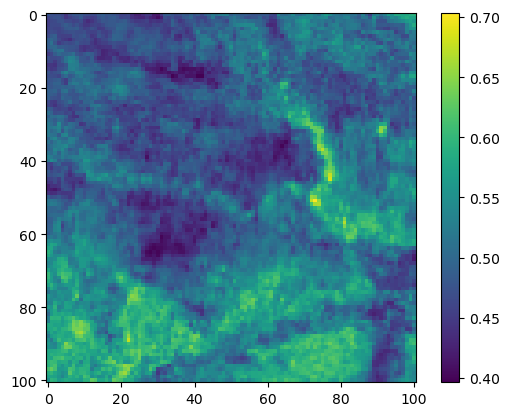

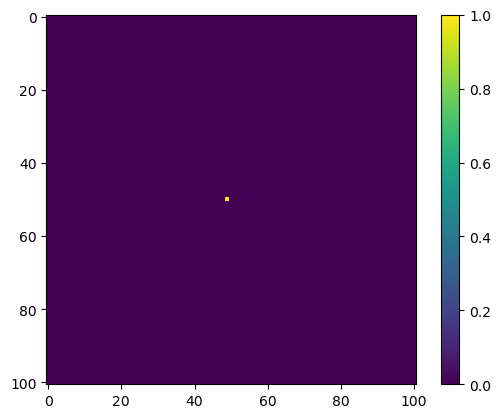

torch.Size([32, 101, 101, 2])
0.9999997511680989


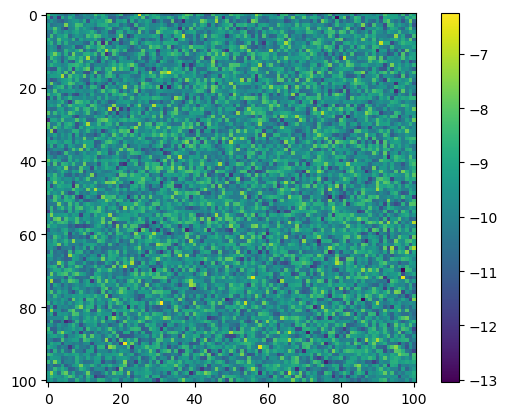

1.0


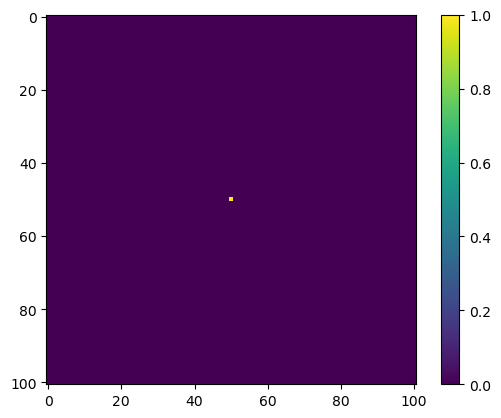

torch.Size([101, 101])
3.609553057928914e-05


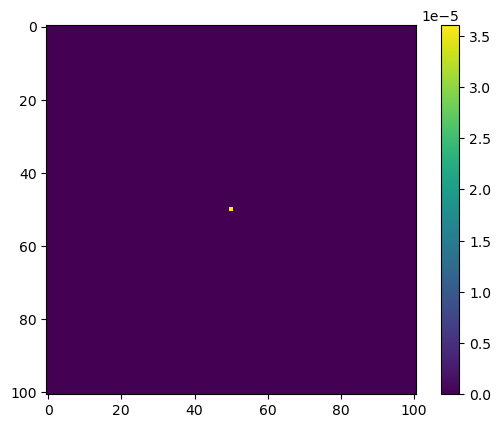

In [54]:
# 1. Set the model in evaluation mode
model.eval()

# Display image and label.
x1, x2, labels = next(iter(dataloader))
print(f"Feature batch shape: {x1.size()}")
print(f"Feature batch shape: {x2.size()}")
print(f"Labels batch shape: {labels.size()}")

print(x2.detach().numpy()[0,:])

print(loss_fn(model((x1, x2)), labels))

# plot the covariates
plt.imshow(x1.detach().numpy()[0,0,:,:])
plt.colorbar()
plt.show()

# plot the target
plt.imshow(labels.detach().numpy()[0,:,:])
plt.colorbar()
plt.show()

#Test that the model runs
# x1, x2 = synth_ds[0][0], synth_ds[0][1]
test = model((x1, x2))
print(test.shape)
# print(test)

print(np.sum(np.exp(test.detach().numpy()[0,:,:,0])))

# plot the results of the habitat density as an image
plt.imshow(test.detach().numpy()[0,:,:,0])
# plt.imshow(np.exp(test.detach().numpy()[0,:,:,0]))
plt.colorbar()
plt.show()

print(np.sum(np.exp(test.detach().numpy()[0,:,:,1])))

# plot the results of the movement density as an image
plt.imshow(np.exp(test.detach().numpy()[0,:,:,1]))
plt.colorbar()
plt.show()

test_cat = torch.exp(test[0, :, :, 0] + test[0, :, :, 1])
# test_cat = test_cat/torch.sum(test_cat) 
print(test_cat.shape)

print(np.sum(test_cat.detach().numpy()[:,:]))

plt.imshow(test_cat.detach().numpy()[:,:])
plt.colorbar()
plt.show()

## Generate predictions

torch.Size([1, 4, 101, 101])


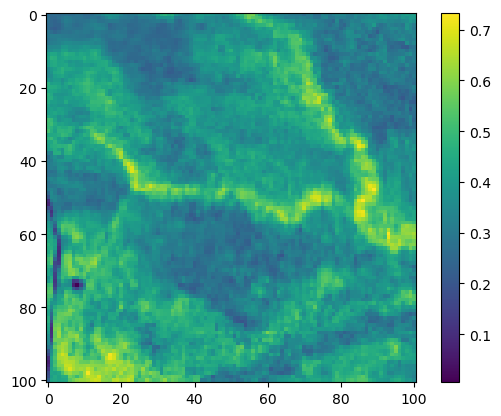

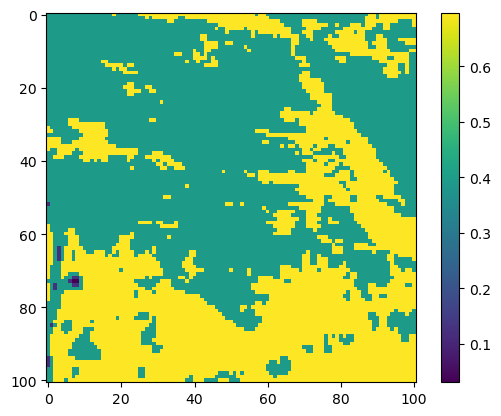

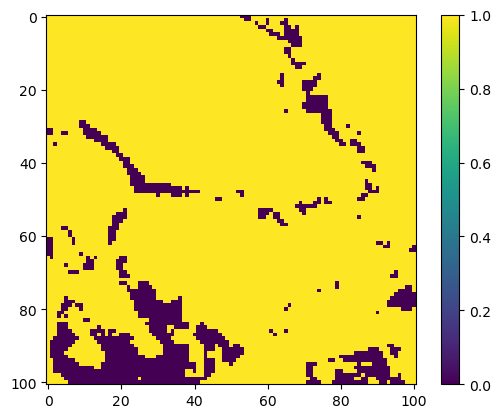

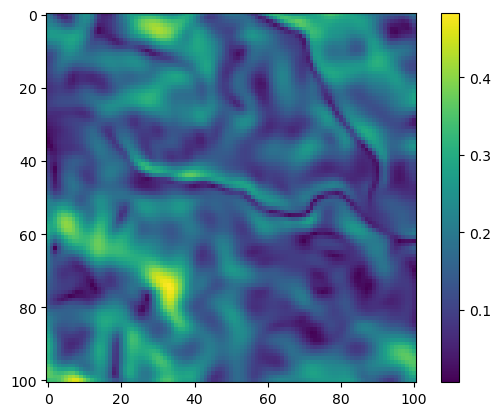

In [ ]:
# 1. Set the model in evaluation mode
model.eval()

# 2. Setup the inference mode context manager
# with torch.inference_mode():
#   # 3. Make sure the calculations are done with the model and data on the same device
#   # in our case, we haven't setup device-agnostic code yet so our data and model are
#   # on the CPU by default.
#   # model_0.to(device)
#   # X_test = X_test.to(device)
#   y_preds = model(X_test)
# y_preds

pred_x = train_dl.dataset.tensors[0][300,:,:,:].unsqueeze(0)
print(pred_x.shape)

for i in range(0, 4):
    plt.imshow(pred_x[0, i].numpy())
    plt.colorbar()  
    plt.show()

# Display the plot
plt.show()

In [ ]:
with torch.no_grad():
  logits = model(pred_x)
logits

IndexError: index 1 is out of bounds for dimension 0 with size 1

## Predict next step

Looping over training data

In [ ]:
# 1. Set the model in evaluation mode
model.eval()

for i in range(0, 100):

  pred_x = train_dl.dataset.tensors[0][i*10,:,:,:].unsqueeze(0)
  pred_y = train_dl.dataset.tensors[1][i*10].unsqueeze(0)

  with torch.no_grad():
    logits = model(pred_x)
  print(logits)


tensor([[112.9670,   0.3044]])
tensor([[108.1753,   0.2917]])
tensor([[107.4488,   0.2897]])
tensor([[111.2305,   0.2993]])
tensor([[110.6339,   0.2980]])
tensor([[111.2305,   0.2993]])
tensor([[107.7297,   0.2893]])
tensor([[112.4803,   0.3031]])
tensor([[110.5990,   0.2970]])
tensor([[112.8929,   0.3042]])
tensor([[111.2305,   0.2993]])
tensor([[110.4891,   0.2975]])
tensor([[108.3680,   0.2919]])
tensor([[109.1773,   0.2943]])
tensor([[111.2305,   0.2993]])
tensor([[107.3570,   0.2894]])
tensor([[113.0013,   0.3043]])
tensor([[108.6700,   0.2937]])
tensor([[111.6251,   0.3009]])
tensor([[110.4233,   0.2970]])
tensor([[109.2448,   0.2949]])
tensor([[110.0884,   0.2951]])
tensor([[110.4247,   0.2966]])
tensor([[111.5177,   0.3000]])
tensor([[110.5575,   0.2970]])
tensor([[109.4027,   0.2950]])
tensor([[107.7297,   0.2893]])
tensor([[111.9456,   0.3017]])
tensor([[111.5485,   0.3009]])
tensor([[110.4692,   0.2965]])
tensor([[109.4027,   0.2950]])
tensor([[110.1033,   0.2961]])
tensor([